In [1]:
# All imports


from __future__ import print_function, division

#!pip install monai
import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

import scipy
from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu
import matplotlib.patches as patches

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

from ipywidgets import IntProgress
#from ipywidgets import IProgress
# [STAR] All imports for DBT

import os
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
from duke_dbt_data import dcmread_image, read_boxes, draw_box, evaluate
np.random.seed(0)
#torch.manual_seed(0)!pip install monai

# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

In [2]:
# [STAR] Pytorch Models for training

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Down_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv_3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Up_3D(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up   = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv_3D(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class OutConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv_3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc   = DoubleConv_3D(n_channels, 16)
        self.down1 = Down_3D(16, 32)
        self.down2 = Down_3D(32, 64)
        self.down3 = Down_3D(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down_3D(128, 256 // factor)
        self.up1 = Up_3D(256, 128 // factor, bilinear)
        self.up2 = Up_3D(128, 64 // factor, bilinear)
        self.up3 = Up_3D(64, 32 // factor, bilinear)
        self.up4 = Up_3D(32, 16, bilinear)
        self.outc = OutConv_3D(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.2)
        self.dp2 = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
        #x3 = self.dp1(x3)
        
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
        #x4 = self.dp2(x4)
        
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_with_BN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_with_BN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.BatchNorm2d(16)
        self.gn2 = nn.BatchNorm2d(32)
        self.gn3 = nn.BatchNorm2d(64)
        self.gn4 = nn.BatchNorm2d(128)
        self.gn5 = nn.BatchNorm2d(64)
        self.gn6 = nn.BatchNorm2d(32)
        self.gn7 = nn.BatchNorm2d(16)
        
        self.dp1 = nn.Dropout(p=0.4)
        self.dp2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class SUNet_without_GN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet_without_GN, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x, x3)
        x  = self.up3(x, x2)
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

class AttnDecoderRNN_old(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

############### MAIN MODEL ##############
class UNetDoubleSmallGroupNormdifferent_old(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5 shape is :',x5.shape)
        
        xlst = x5.reshape([4,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc     = DoubleConv(n_channels, 16)
        self.down1   = Down(16, 32)
        self.downnew = Down(16,16)
        self.down2   = Down(32, 64)
        self.down3   = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4   = Down(128, 256 // factor) 
        self.upsam   = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.down5 = Down(128,256)
        self.ups3  = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        self.lsgn2 = nn.GroupNorm(64,1024)
        self.lsgn3 = nn.GroupNorm(64,1024)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        #x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        #x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        #x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        #x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        #x5 = self.gn
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgn1(xlst)
        ylst = lstm(xlst)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))
        #a = ndarray((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo   = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        #x5 = self.lsgn3(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
        #x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        #x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class UNetDoubleSmallWithoutGN(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallWithoutGN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.down5 = Down(128,256)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)
        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p   = dropout_p
        self.max_length  = max_length
        self.bilinear    = bilinear
        self.n_classes   = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn      = nn.Linear(2048, 1024)
        
        self.attn2   = nn.Linear(1024, 128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru     = nn.GRU(1024, 1024)
        self.out     = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        #self.lsgn_a = nn.GroupNorm(512,1024)
        self.lsbn_a1 = nn.BatchNorm1d(1024)
        #self.lsgn_a2 = nn.GroupNorm(512,1024)
        
        #self.lsgn_in = nn.GroupNorm(64,128)
        self.lsbn_in1 = nn.BatchNorm1d(2048)
        self.lsbn_in2 = nn.BatchNorm1d(1024)
        
        
        self.lsbn_in3 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in4 = nn.BatchNorm1d(128)#nn.GroupNorm(64,   128)
        self.lsbn_in5 = nn.BatchNorm1d(1024)#nn.GroupNorm(512,  1024)
        
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h        = torch.unsqueeze(hidden, 0)
        embedded = input
        #embedded = self.lsgn_in1(embedded)
        embedded = self.dropout(embedded)
        
        hidden_bilstm = h[0]
        hidden_bilinn = hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        hidden_bilinn = self.lsbn_a1(hidden_bilinn)
        
        hidden_bi     = hidden_bilinn.unsqueeze(0)
        
        #print(hidden_bilinn.shape)
        
        attn_weights  = torch.cat((embedded[0], hidden_bilinn), 1)
        attn_weights  = self.lsbn_in1(attn_weights)
        
        attn_weights  = self.attn(attn_weights)
        attn_weights  = self.lsbn_in2(attn_weights)
        
        attn_weights  = F.softmax(attn_weights, dim=1)
        
        attn_weights  = self.attn2(attn_weights)
        attn_weights  = self.lsbn_in3(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        output = F.relu(output)
        output = self.lsbn_in4(output)
        
        output, hidden = self.gru(output, hidden_bi)
        
        output = self.out(output[0])
        output = self.lsbn_in5(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=1, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out
    
class UNetNormal(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNetNormal, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        my_factor = 1
        factor    = 1
        
        self.inc   = DoubleConv(n_channels, 32*my_factor)
        self.down1 = Down(32*my_factor, 64*my_factor)
        self.down2 = Down(64*my_factor, 128*my_factor)
        self.down3 = Down(128*my_factor, 256*my_factor)
        factor = 2 if bilinear else 1
        self.down4 = Down(256*my_factor, 512*my_factor // factor)
        
        self.lsgn1 = nn.GroupNorm(256,512)
        self.lsgn2 = nn.GroupNorm(512,1024)
        
        self.up1 = Up(512*my_factor, 256*my_factor // factor, bilinear)
        self.up2 = Up(256*my_factor, 128*my_factor // factor, bilinear)
        self.up3 = Up(128*my_factor, 64*my_factor // factor, bilinear)
        self.up4 = Up(64*my_factor, 32*my_factor, bilinear)
        self.outc = OutConv(32*my_factor, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet_3D(1, 1)
#model.cuda()

In [ ]:
# [STAR] Read all the slices in training set without augmentation

basepath = '/home/drilnvm/DBTex/'
df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

for i in tqdm(range(224)):
    box_series  = df.iloc[i]
    view        = box_series["View"]
    slice_index = box_series["Slice"]
    image_path  = os.path.join(basepath, box_series["descriptive_path"])
    image       = dcmread_image(fp=image_path, view=view, index=slice_index-1)
    
    #trainx.append(image[slice_index-1:slice_index+1])
    #trainx.append(image[slice_index])
    trainx.append(image)
    trainy.append(box_series["Class"])
    #image = image[slice_index]
    
    x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
    #image               = draw_box(image=image, x=x, y=y, width=width, height=height, lw=10)
    #boximage.append(image)
    coordx.append(x)
    coordy.append(y)
    width_arr.append(width)
    height_arr.append(height)

print(len(trainx), len(trainy), len(boximage))

# mx = 0
# my = 0
# for i in range(len(trainx)):
#     if trainx[i].shape[0] > mx:
#         mx = trainx[i].shape[0]
#     if trainx[i].shape[1] > my:
#         my = trainx[i].shape[1]
# print(mx, my)

if(1):
    np.save('coordx.npy', coordx)
    np.save('coordy.npy', coordy)

    newtrainx  = np.zeros([len(trainx), 1, 3000, 2000], 'float16')
    newtrainy  = np.zeros([len(trainx), 1], 'float16')
    for i in range(len(trainx)):
        newtrainx[i, 0, :trainx[i].shape[0], :trainx[i].shape[1]] = trainx[i]
        if trainy[i] == 'benign':
            newtrainy[i, 0] = 0
        else:
            newtrainy[i, 0] = 1

    np.save('trainx.npy', newtrainx)
    np.save('trainy.npy', newtrainy)

In [40]:
# [STAR] DBT classes for data loader

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        suffix_str  = ''#random.choice(['_m2', '_m1', '_p1', '_p2', ''])
        print('READING NEW FILE >> ', suffix_str, ' <<')
        
        #shuffle_index = np.arange(224)
        #np.random.shuffle(shuffle_index)
        #np.save('shuffle_array.npy', shuffle_index)
        #shuffle_index = np.load('shuffle_array.npy')
        
        trainx = np.load('trainx'+suffix_str+'.npy')
        trainy = np.load('trainy'+suffix_str+'.npy')
        coordx = np.load('coordx'+suffix_str+'.npy')
        coordy = np.load('coordy'+suffix_str+'.npy')
        width_arr  = np.load('width_arr'+suffix_str+'.npy')
        height_arr = np.load('height_arr'+suffix_str+'.npy')
        
        #trainx = trainx[shuffle_index]
        #trainy = trainy[shuffle_index]
        #coordx = coordx[shuffle_index]
        #coordy = coordy[shuffle_index]
        #width_arr  = width_arr[shuffle_index]
        #height_arr = height_arr[shuffle_index]
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 175
        else:
            self.train_start  = 175
            self.train_end    = 220
        
        self.train_set = train_set
        #t1 = np.load('trainx_m1.npy')[self.train_start:self.train_end]
        #t2 = np.load('trainx.npy')[self.train_start:self.train_end]
        #t3 = np.load('trainx_p1.npy')[self.train_start:self.train_end]
        #self.trainx  =  np.concatenate([t2, t1, t3], axis=1)
        
        self.trainx = trainx[self.train_start:self.train_end]#.astype('float16')/60000.0
        self.trainy = trainy[self.train_start:self.train_end]
        self.coordx = coordx[self.train_start:self.train_end]
        self.coordy = coordy[self.train_start:self.train_end]
        self.width_arr  = width_arr[self.train_start:self.train_end]
        self.height_arr = height_arr[self.train_start:self.train_end]
        
        print('Total size of dataset ', len(np.load('width_arr'+suffix_str+'.npy')))
#         self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#         self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
#         self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
#         self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
#         self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
#         self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        self.transforms1 = A.Compose(
                                    [A.HorizontalFlip(p=0.5),  A.VerticalFlip(p=0.5), ],
                                     #A.Downscale(scale_min=0.95, scale_max=0.98, p=0.25, interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        #if self.counter % 10 == 0:
        #    print('Counter is ', self.counter)
        
#         if self.train_set == 1 and self.counter % 150 == 0 and random.random() < 0.2:
#             suffix_str  = random.choice([ '_m1', '_p1', ''])
#             print('READING NEW FILE >> ', suffix_str, ' <<')
#             self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#             self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
                
        #img = self.trainx[idx].astype('float32')/60000.0
        img = self.trainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]/4, self.coordy[idx]/4, self.width_arr[idx]/4, self.height_arr[idx]/4])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        area = self.width_arr[idx] * self.height_arr[idx]
        area = torch.Tensor(area)
        
        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)
        
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

class DBTDatasetValidation(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        
        image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol        = dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.zeros([len(self.vol), 1, 3000, 2000], 'float16')
        for i in range(len(self.vol)):
            self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        
        print('File reading done ', self.vol.shape, image_path)
        #print()
        
    def __getitem__(self, idx):
        
        img          = self.newtrainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        target              = {}
        target['image_id']  = torch.tensor([idx])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

class DBTDatasetValidationTrain(torch.utils.data.Dataset):
    def __init__(self, val_index = 0, transforms = None):
        super().__init__()
        
        self.basepath  = '/home/drilnvm/DBTex/'
        self.counter   = 0
        self.val_index = val_index
        self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
        #self.df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
        
        box_series       = self.df.iloc[self.val_index]
        self.PatientID   = box_series["PatientID"]
        self.StudyUID    = box_series["StudyUID"]
        self.view        = box_series["View"]
        self.slice_index = box_series["Slice"]
        self.X           = box_series["X"]
        self.Y           = box_series["Y"]
        self.Width       = box_series["Width"]
        self.Height      = box_series["Height"]
        #Slice,X,Y,Width,Height
        
        #image_path      = os.path.join(self.basepath, box_series["descriptive_path"])
        self.vol = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+self.PatientID+'_'+self.StudyUID+'_'+self.view+'.npy')
        #self.vol        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(val_index)+'.npy')#dcmread_image(fp=image_path, view=self.view)
        self.newtrainx  = np.expand_dims(self.vol, 1)#np.zeros([len(self.vol), 1, 750, 500], 'float16')
        #for i in range(len(self.vol)):
        #    self.newtrainx[i, 0, :self.vol[i].shape[0], :self.vol[i].shape[1]] = self.vol[i]
        print('File reading done ',            self.vol.shape)
        #print('Inside DBTDatasetValidationTrain ', box_series)
        
        #print(box_series["descriptive_path"])
        
    def __getitem__(self, idx):
        img          = self.newtrainx[idx, 0].astype('float32')#/60000.0
        img[img > 1] = 1
        #img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        
        target              = {}
        if idx == self.slice_index:
            target['boxes']  = torch.tensor([self.X, self.Y, self.X+self.Width, self.Y+self.Height])
        
        return img, target, idx
    
    def __len__(self):
        return self.vol.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [41]:
# [STAR] DBT Dataset and Model Creation

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model       = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
lr_scheduler = None

READING NEW FILE >>    <<
Total size of dataset  224
READING NEW FILE >>    <<
Total size of dataset  224


In [42]:
# [STAR] Training loop for DBT dataset

loss_hist     = Averager()
val_loss_hist = Averager()

prev_min   = 1000
num_epochs = 10
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_hist.reset()
    
    model.train()
    itr = 1
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #if itr % 50 == 0:
        #    print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    with torch.no_grad():
        for images, targets, image_ids in valid_data_loader:
            new_images  = []
            for img in images:
                new_images.append(torch.Tensor(img).to(device))

            images    = new_images
            targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            #print(loss_dict)

            losses     = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_hist.send(loss_value)

            #if itr % 50 == 0:
            #    print(f"Validation Iteration #{itr} loss: {loss_value}")
            itr = itr+1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    if val_loss_hist.value < prev_min:
        print(f"Epoch #{epoch} Train loss: {loss_hist.value}")
        print(f"Epoch #{epoch} Val   loss: {val_loss_hist.value}")
        print('Saving the model ', prev_min, val_loss_hist.value)
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt25.pth')
        prev_min = val_loss_hist.value

Epoch #0 Train loss: 0.24805516038428654
Epoch #0 Val   loss: 0.20107608354753917
Saving the model  1000 0.20107608354753917
Epoch #1 Train loss: 0.19063299995931712
Epoch #1 Val   loss: 0.1944615145524343
Saving the model  0.20107608354753917 0.1944615145524343
Epoch #2 Train loss: 0.17734958468513054
Epoch #2 Val   loss: 0.18896096445344113
Saving the model  0.1944615145524343 0.18896096445344113
Epoch #3 Train loss: 0.16284725290130486
Epoch #3 Val   loss: 0.18728316101349063
Saving the model  0.18896096445344113 0.18728316101349063


In [43]:
# [STAR] For printing the loss of the trained model

# fasterrcnn_resnet50_dbt7.pth  0.24080992616713048
# fasterrcnn_resnet50_dbt8.pth  0.1653416310250759
# fasterrcnn_resnet50_dbt9.pth  0.17630461007356643
# fasterrcnn_resnet50_dbt10.pth 0.17438715264201166
# fasterrcnn_resnet50_dbt11.pth 0.16590506657958032
# fasterrcnn_resnet50_dbt14.pth 0.1608045955002308
# fasterrcnn_resnet50_dbt21.pth 0.15965028703212739
# fasterrcnn_resnet50_dbt15.pth (3 adjacent channel)

all_target    = []
all_scores    = []
val_loss_hist = Averager()
itr = 1

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.train()

with torch.no_grad():
    for images, targets, image_ids in valid_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        #print(loss_dict)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_hist.send(loss_value)

        if itr % 10 == 0:
            print(f"Validation Iteration #{itr} loss: {loss_value}")
        itr = itr+1

print(val_loss_hist.value)

Validation Iteration #10 loss: 0.15957418084144592
Validation Iteration #20 loss: 0.2850976288318634
Validation Iteration #30 loss: 0.21906031668186188
Validation Iteration #40 loss: 0.2091214954853058
0.18152466780609555


In [44]:
# [STAR] For Obtaining the result on Validation set of the Challenge

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt25.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr  = []
height_arr = []

PatientID_arr = []
StudyUID_arr  = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]
        
basepath = '/home/drilnvm/DBTex/'
df = read_boxes(boxes_fp=basepath+"BCS-DBT-boxes-train.csv", filepaths_fp=basepath+"BCS-DBT-file-paths-train.csv")

    
for i in tqdm(range(175, 224)):
    #if i in shuffle_index:
    
    #else:
    #    continue
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
    
    print('Processing ', i, PatientID, StudyUID, view)
    
    #slice_index = box_series["Slice"]
    #image_path  = os.path.join(basepath, box_series["descriptive_path"])
    #print(box_series)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        #print(targets)
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        #targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images)
        #print(loss_dict)
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    with open('/media/drilnvm/ubuntudata2/DBTEx_results25/'+PatientID+'_'+StudyUID+'_'+view+'_score_'+str(i)+'.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_scores, filehandle)
        
    with open('/media/drilnvm/ubuntudata2/DBTEx_results25/'+PatientID+'_'+StudyUID+'_'+view+'_target_'+str(i)+'.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

  0%|          | 0/49 [00:00<?, ?it/s]

Processing  175 DBT-P03658 DBT-S05241 rmlo
File reading done  (78, 750, 500)


  2%|▏         | 1/49 [00:04<03:38,  4.56s/it]

Processing  176 DBT-P03677 DBT-S00709 lcc
File reading done  (78, 750, 500)


  4%|▍         | 2/49 [00:09<03:33,  4.54s/it]

Processing  177 DBT-P03677 DBT-S00709 lmlo
File reading done  (73, 750, 500)


  6%|▌         | 3/49 [00:13<03:24,  4.45s/it]

Processing  178 DBT-P03677 DBT-S00709 rcc
File reading done  (76, 750, 500)


  8%|▊         | 4/49 [00:17<03:19,  4.43s/it]

Processing  179 DBT-P03677 DBT-S00709 rcc
File reading done  (76, 750, 500)


 10%|█         | 5/49 [00:22<03:14,  4.42s/it]

Processing  180 DBT-P03677 DBT-S00709 rmlo
File reading done  (75, 750, 500)


 12%|█▏        | 6/49 [00:26<03:09,  4.40s/it]

Processing  181 DBT-P03677 DBT-S00709 rmlo
File reading done  (75, 750, 500)


 14%|█▍        | 7/49 [00:30<03:04,  4.39s/it]

Processing  182 DBT-P03748 DBT-S02094 lcc
File reading done  (78, 750, 500)


 16%|█▋        | 8/49 [00:35<03:01,  4.43s/it]

Processing  183 DBT-P03748 DBT-S02094 lmlo
File reading done  (74, 750, 500)


 18%|█▊        | 9/49 [00:39<02:55,  4.40s/it]

Processing  184 DBT-P03816 DBT-S03888 rcc
File reading done  (70, 750, 500)


 20%|██        | 10/49 [00:43<02:47,  4.31s/it]

Processing  185 DBT-P03816 DBT-S03888 rmlo
File reading done  (85, 750, 500)


 22%|██▏       | 11/49 [00:48<02:50,  4.50s/it]

Processing  186 DBT-P03915 DBT-S05004 lcc
File reading done  (72, 750, 500)


 24%|██▍       | 12/49 [00:52<02:42,  4.40s/it]

Processing  187 DBT-P03978 DBT-S00442 rcc
File reading done  (50, 750, 500)


 27%|██▋       | 13/49 [00:55<02:22,  3.96s/it]

Processing  188 DBT-P03978 DBT-S00442 rmlo
File reading done  (45, 750, 500)


 29%|██▊       | 14/49 [00:58<02:04,  3.56s/it]

Processing  189 DBT-P04026 DBT-S01650 rcc1
File reading done  (65, 750, 500)


 31%|███       | 15/49 [01:02<02:03,  3.63s/it]

Processing  190 DBT-P04026 DBT-S01650 rmlo
File reading done  (58, 750, 500)


 33%|███▎      | 16/49 [01:05<01:57,  3.56s/it]

Processing  191 DBT-P04090 DBT-S01718 rcc
File reading done  (87, 750, 500)


 35%|███▍      | 17/49 [01:10<02:08,  4.00s/it]

Processing  192 DBT-P04090 DBT-S01718 rmlo
File reading done  (80, 750, 500)


 37%|███▋      | 18/49 [01:15<02:10,  4.20s/it]

Processing  193 DBT-P04116 DBT-S03961 rcc
File reading done  (80, 750, 500)


 39%|███▉      | 19/49 [01:19<02:10,  4.35s/it]

Processing  194 DBT-P04116 DBT-S03961 rmlo
File reading done  (83, 750, 500)


 41%|████      | 20/49 [01:24<02:10,  4.49s/it]

Processing  195 DBT-P04326 DBT-S03750 lcc
File reading done  (79, 750, 500)


 43%|████▎     | 21/49 [01:29<02:06,  4.52s/it]

Processing  196 DBT-P04326 DBT-S03750 lmlo
File reading done  (93, 750, 500)


 45%|████▍     | 22/49 [01:34<02:09,  4.79s/it]

Processing  197 DBT-P04372 DBT-S04281 lcc
File reading done  (72, 750, 500)


 47%|████▋     | 23/49 [01:39<01:59,  4.61s/it]

Processing  198 DBT-P04372 DBT-S04281 lmlo
File reading done  (81, 750, 500)


 49%|████▉     | 24/49 [01:43<01:56,  4.65s/it]

Processing  199 DBT-P04429 DBT-S00568 lcc
File reading done  (76, 750, 500)


 51%|█████     | 25/49 [01:48<01:50,  4.59s/it]

Processing  200 DBT-P04429 DBT-S00568 lmlo
File reading done  (74, 750, 500)


 53%|█████▎    | 26/49 [01:52<01:43,  4.51s/it]

Processing  201 DBT-P04631 DBT-S05515 lcc
File reading done  (70, 750, 500)


 55%|█████▌    | 27/49 [01:56<01:36,  4.38s/it]

Processing  202 DBT-P04631 DBT-S05515 lmlo
File reading done  (83, 750, 500)


 57%|█████▋    | 28/49 [02:01<01:34,  4.52s/it]

Processing  203 DBT-P04710 DBT-S03227 rcc
File reading done  (76, 750, 500)


 59%|█████▉    | 29/49 [02:05<01:30,  4.51s/it]

Processing  204 DBT-P04710 DBT-S03227 rmlo
File reading done  (75, 750, 500)


 61%|██████    | 30/49 [02:10<01:25,  4.50s/it]

Processing  205 DBT-P04721 DBT-S01833 lcc
File reading done  (67, 750, 500)


 63%|██████▎   | 31/49 [02:14<01:18,  4.38s/it]

Processing  206 DBT-P04721 DBT-S01833 lmlo
File reading done  (63, 750, 500)


 65%|██████▌   | 32/49 [02:18<01:10,  4.17s/it]

Processing  207 DBT-P04750 DBT-S00052 rcc
File reading done  (63, 750, 500)


 67%|██████▋   | 33/49 [02:21<01:04,  4.02s/it]

Processing  208 DBT-P04818 DBT-S02975 rcc
File reading done  (76, 750, 500)


 69%|██████▉   | 34/49 [02:26<01:02,  4.14s/it]

Processing  209 DBT-P04818 DBT-S02975 rmlo
File reading done  (79, 750, 500)


 71%|███████▏  | 35/49 [02:30<00:59,  4.28s/it]

Processing  210 DBT-P04858 DBT-S04555 lmlo
File reading done  (66, 750, 500)


 73%|███████▎  | 36/49 [02:34<00:54,  4.15s/it]

Processing  211 DBT-P04858 DBT-S04555 rcc
File reading done  (61, 750, 500)


 76%|███████▌  | 37/49 [02:38<00:47,  3.98s/it]

Processing  212 DBT-P04901 DBT-S05032 rcc
File reading done  (60, 750, 500)


 78%|███████▊  | 38/49 [02:41<00:42,  3.84s/it]

Processing  213 DBT-P04901 DBT-S05032 rmlo
File reading done  (64, 750, 500)


 80%|███████▉  | 39/49 [02:45<00:38,  3.81s/it]

Processing  214 DBT-P05014 DBT-S04931 rcc
File reading done  (80, 750, 500)


 82%|████████▏ | 40/49 [02:50<00:36,  4.07s/it]

Processing  215 DBT-P05014 DBT-S04931 rmlo
File reading done  (75, 750, 500)


 84%|████████▎ | 41/49 [02:54<00:33,  4.16s/it]

Processing  216 DBT-P05022 DBT-S05195 rcc
File reading done  (75, 750, 500)


 86%|████████▌ | 42/49 [02:58<00:29,  4.22s/it]

Processing  217 DBT-P05022 DBT-S05195 rmlo
File reading done  (72, 750, 500)


 88%|████████▊ | 43/49 [03:03<00:25,  4.21s/it]

Processing  218 DBT-P05030 DBT-S05569 rcc
File reading done  (75, 750, 500)


 90%|████████▉ | 44/49 [03:07<00:21,  4.26s/it]

Processing  219 DBT-P05030 DBT-S05569 rmlo
File reading done  (74, 750, 500)


 92%|█████████▏| 45/49 [03:11<00:17,  4.28s/it]

Processing  220 DBT-P05047 DBT-S05588 rcc
File reading done  (78, 750, 500)


 94%|█████████▍| 46/49 [03:16<00:13,  4.38s/it]

Processing  221 DBT-P05047 DBT-S05588 rmlo
File reading done  (76, 750, 500)


 96%|█████████▌| 47/49 [03:20<00:08,  4.41s/it]

Processing  222 DBT-P05056 DBT-S01839 rcc
File reading done  (72, 750, 500)


 98%|█████████▊| 48/49 [03:25<00:04,  4.35s/it]

Processing  223 DBT-P05056 DBT-S01839 rmlo
File reading done  (65, 750, 500)


100%|██████████| 49/49 [03:28<00:00,  4.27s/it]


In [51]:
# [STAR] For writing the csv file for submission

# 0.25 -> output3 -> score_2 0.648, score_3 0.68
# 0.50 -> output2 -> score_2 0.646, score_3 0.65

from scipy.signal import find_peaks

total_prediction = ["PatientID,StudyUID,View,X,Width,Y,Height,Z,Depth,Score"]
prediction_lines = []

#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
#df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-train.csv')
df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv')
print('Total validation length ', len(df))

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]


#for case_index in range(175, 224):
for case_index in range(175, 224):
    #if case_index not in shuffle_index:
    #    continue
    
    box_series  = df.iloc[case_index]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view_name   = box_series["View"]
    
    
    #img        = np.load('/media/drilnvm/ubuntudata2/DBTEx_numpy1/val_vol_'+str(case_index)+'.npy')
    all_target = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results25/'+PatientID+'_'+StudyUID+'_'+view_name+'_target_'+str(case_index)+'.data', 'rb'))
    all_scores = pickle.load(open('/media/drilnvm/ubuntudata2/DBTEx_results25/'+PatientID+'_'+StudyUID+'_'+view_name+'_score_'+str(case_index)+'.data', 'rb'))
    
    #print(PatientID, StudyUID, view_name,  len(all_target), len(all_scores))
    
    d_init_x = -1
    d_init_y = -1
    d_init_z = -1
    all1     = []
    
    for i, t in enumerate(all_scores):
        if len(t) > 0 and t[0] > 0.5:
            if d_init_x == -1:
                d_init_x = all_target[i][0][0]
                d_init_y = all_target[i][0][1]
                d_init_z = i
        
            temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
            all1.append(temp_dist)
            
            # update previous coordinate
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        else:
            all1.append(100)
    
    all1     = 100-np.array(all1)
    peaks, _ = find_peaks(all1, distance=4, width=3)
    #peaks, _ = find_peaks(all1, distance=4, plateau_size=4)
    
    for p in peaks:
        temp = all_target[p][0]*4
        result_string = [PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]), p, 8, all_scores[p][0]]
        result_string = [str(x) for x in result_string]
        result_string = ",".join(result_string)
        
        #print(PatientID, StudyUID, view_name, temp, all_scores[p][0])
        #print(PatientID, StudyUID, view_name, int(temp[0]), int(temp[2]- temp[0]), int(temp[1]), int(temp[3]-temp[1]))
        print(result_string)
        total_prediction.append(result_string)
        #print(temp)
        #print(temp[0], temp[2]-temp[0], temp[1], temp[3]-temp[1], all_scores[p][0])
        #print(all_score[p])
    #total_prediction.append(len(peaks))
    #print(len(peaks), len(all1), len(all_target), len(all_scores))
    break

print('Total Prediction ', len(total_prediction))
total_prediction = "\n".join(total_prediction)

text_file = open("model_result5.csv", "w")
text_file.write(total_prediction)
text_file.close()


#plt.plot(all1)
#plt.plot(peaks, all1[peaks], 'x')

Total validation length  224
DBT-P03658,DBT-S05241,rmlo,1763,213,96,182,22,8,0.81263536
DBT-P03658,DBT-S05241,rmlo,1044,214,1612,214,63,8,0.5722631
DBT-P03677,DBT-S00709,lcc,285,221,1032,463,42,8,0.6317786
DBT-P03677,DBT-S00709,lcc,220,285,1006,283,53,8,0.73361546
DBT-P03677,DBT-S00709,lmlo,0,116,85,122,17,8,0.5756018
DBT-P03677,DBT-S00709,lmlo,0,114,91,117,22,8,0.7432487
DBT-P03677,DBT-S00709,lmlo,397,246,1195,392,29,8,0.5984555
DBT-P03677,DBT-S00709,lmlo,311,236,1360,335,45,8,0.7659871
DBT-P03677,DBT-S00709,lmlo,262,301,1381,337,50,8,0.72628415
DBT-P03677,DBT-S00709,lmlo,303,271,1326,307,60,8,0.54247487
DBT-P03677,DBT-S00709,rcc,1579,335,1388,714,7,8,0.56710875
DBT-P03677,DBT-S00709,rcc,1529,426,1589,468,19,8,0.8489964
DBT-P03677,DBT-S00709,rcc,1565,310,1535,294,31,8,0.74650955
DBT-P03677,DBT-S00709,rcc,1598,226,1395,374,39,8,0.77168953
DBT-P03677,DBT-S00709,rcc,1740,156,769,292,52,8,0.6725952
DBT-P03677,DBT-S00709,rcc,1735,160,774,299,62,8,0.6883447
DBT-P03677,DBT-S00709,rcc,1579,33

In [52]:
# [STAR] For getting the AUC on the Train remaining split

from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union

labels_fp = "/home/drilnvm/DBTex//BCS-DBT-labels-train.csv"
boxes_fp  = "/home/drilnvm/DBTex/BCS-DBT-boxes-train.csv"
#predictions_fp = "/media/drilnvm/ubuntudata2/train_val.csv"
predictions_fp = "model_result5.csv"

df_labels = pd.read_csv(labels_fp)
df_boxes  = pd.read_csv(boxes_fp, dtype={"Slice": float})
df_pred   = pd.read_csv(predictions_fp, dtype={"Score": float})

#df_boxes = df_boxes.iloc[shuffle_index].tail(74)
df_boxes = df_boxes.loc[175:224]

df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_boxes  = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
df_pred   = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

def _is_tp(
    box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100
) -> bool:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    #pred_z = box_pred.Z + box_pred.Depth / 2
    pred_z = box_pred.Z #+ 4 / 2
    
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    
    # 2D distance between true and predicted center points
    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    # compute radius based on true box size
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff     = np.abs(pred_z - true_z)
    
    # TP if predicted center within radius and slice within slice offset
    tp_flag = dist <= dist_threshold and slice_diff <=  slice_offset
    
    #print(pred_x, pred_y, pred_z)
    #print(true_x, true_y, true_z)
    #print(dist, dist_threshold, slice_diff, slice_offset, tp_flag)
    return tp_flag


def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z #+ box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice
    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _froc(
    df_pred: pd.DataFrame,
    thresholds: List[float],
    n_volumes: int,
    n_boxes: int,
    evaluation_fps: tuple,
) -> List[float]:
    tpr = []
    fps = []
    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(
            subset=["StudyUID", "View", "TP", "GTID"]
        )
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)
        if fps_th > max(evaluation_fps):
            break
    return [np.interp(x, fps, tpr) for x in evaluation_fps]

df_pred["TP"]   = 0
df_pred["GTID"] = -1

thresholds = [df_pred["Score"].max() + 1.0]

counter = 0
# find true positive predictions and assign detected ground truth box ID
for box_pred in df_pred.itertuples():
    #print(df_boxes.index)
    #print('---------------------')
    if box_pred.Index not in df_boxes.index:
        continue
    #box_pred.Depth = 4
    counter = counter+1
    #print(box_pred.Index)
    #print('TP found ', box_pred)
    df_boxes_view     = df_boxes.loc[[box_pred.Index]]
    #print("df_boxes.loc ", df_boxes.loc[[box_pred.Index], "Slice"].iloc[0])
    view_slice_offset = df_boxes.loc[[box_pred.Index], "Slice"].iloc[0] / 4
    
    #print(df_boxes_view)
    #print(box_pred)
    #print('---------------------------')
    tp_boxes = [
        b
        for b in df_boxes_view.itertuples()
        if _is_tp(box_pred, b, slice_offset=view_slice_offset)
    ]
    if len(tp_boxes) > 1:
        # find the nearest GT box
        tp_distances = [_distance(box_pred, b) for b in tp_boxes]
        tp_boxes     = [tp_boxes[np.argmin(tp_distances)]]
    if len(tp_boxes) > 0:
        tp_i = tp_boxes[0].index
        df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
        thresholds.append(box_pred.Score)
#print(thresholds)

print('Total counter is ', counter)
thresholds.append(df_pred["Score"].min() - 1.0)

# compute sensitivity at 2 FPs/volume on all cases
evaluation_fps_all = (2.0,)
tpr_all = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_all,
)
result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

# compute mean sensitivity at 1, 2, 3, 4 FPs/volume on positive cases
df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
tpr_positive = _froc(
    df_pred=df_pred,
    thresholds=thresholds,
    n_volumes=len(df_labels),
    n_boxes=len(df_boxes),
    evaluation_fps=evaluation_fps_positive,
)

result.update(
    dict(
        (f"sensitivity_at_{int(x)}_fps_positive", y)
        for x, y in zip(evaluation_fps_positive, tpr_positive)
    )
)
result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

print(result)

Total counter is  188
{'sensitivity_at_2_fps_all': 0.6938775510204082, 'sensitivity_at_1_fps_positive': 0.5306122448979592, 'sensitivity_at_2_fps_positive': 0.6454810495626822, 'sensitivity_at_3_fps_positive': 0.6938775510204082, 'sensitivity_at_4_fps_positive': 0.6938775510204082, 'mean_sensitivity_positive': 0.6409620991253644}


In [ ]:
# [TEMPORARY] For storing the files as numpy
import os

df        = pd.read_csv('/home/drilnvm/DBTex/BCS-DBT-file-paths-validation.csv')
for i in tqdm(range(97, len(df))):
    basepath    = '/home/drilnvm/DBTex/'
    box_series  = df.iloc[i]
    PatientID   = box_series["PatientID"]
    StudyUID    = box_series["StudyUID"]
    view        = box_series["View"]
        
    image_path = os.path.join(basepath, box_series["descriptive_path"])
    #vol        = dcmread_image(fp=image_path, view=view)
    #print(vol.shape)
    #newtrainx  = np.zeros([len(vol), 1, 3000, 2000], 'float16')
    #for i in range(len(vol)):
    #    newtrainx[i, 0, :vol[i].shape[0], :vol[i].shape[1]] = vol[i]
    
    #newtrain1 = []
    #for i in range(len(vol)):
    #    img          = newtrainx[i, 0].astype('float32')/60000.0
    #    img[img > 1] = 1
    #    img = ndimage.interpolation.zoom(img, 0.25).astype('float16')
    #    newtrain1.append(img)
    
    numpy_path = '/media/drilnvm/ubuntudata2/DBTEx_numpy/vol_'+str(i)+'.npy'
    #vol1       = np.load(numpy_path)
    #newtrain1 = np.array(newtrain1)
    print(PatientID, StudyUID, view)#, vol1.shape)
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy', newtrain1)
    temp_path = '/media/drilnvm/ubuntudata2/DBTEx_numpy/'+PatientID+'_'+StudyUID+'_'+view+'.npy'
    os.rename(numpy_path, temp_path)
    #print(i, vol.shape, vol1.shape)
        
#print(len(df))
#df.iloc[0]

In [ ]:
# [STAR] Temporary

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt14.pth'))
model.eval()


trainx = []
trainy = []
boximage  = []
coordx =  []
coordy = []

width_arr = []
height_arr = []

PatientID_arr = []
StudyUID_arr = []

#device = torch.device("cpu")
#model.to(device)


import pickle

#shuffle_index = np.load('shuffle_array.npy')
#shuffle_index = shuffle_index[150:]

    
for i in tqdm(range(150, 151)):
    #if i in shuffle_index:
    print('Processing ', i)
    #else:
    #    continue
    #box_series  = df.iloc[i]
    #view        = box_series["View"]
    #slice_index = box_series["Slice"]
    #image_path  = os.path.join(basepath, box_series["descriptive_path"])
    #print(box_series)
    
    valid_dataset     = DBTDatasetValidationTrain(val_index=i)
    #valid_dataset     = DBTDataset(train_set=0)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1, 
        collate_fn=collate_fn
    )
        
    all_target = []
    all_scores = []
    all_images = []
    
    for images, targets, image_ids in valid_data_loader:
        all_images.append(images[0][0].astype('float16'))
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images)
        #print(loss_dict)
        
        all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
        all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
    
    #with open('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_score_'+str(i)+'.data', 'wb') as filehandle:
    #    # store the data as binary data stream
    #    pickle.dump(all_scores, filehandle)
        
    #with open('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_target_'+str(i)+'.data', 'wb') as filehandle:
    #    # store the data as binary data stream
    #    pickle.dump(all_target, filehandle)
    
    #np.save('/media/drilnvm/ubuntudata2/DBTEx_numpy2/val_vol_'+str(i), np.array(all_images).astype('float16'))

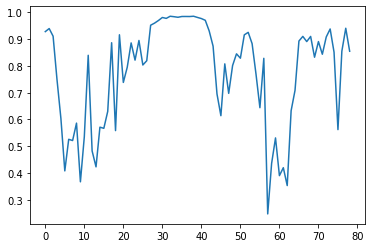

In [288]:
#plt.plot(all_scores)
a1 = []
for k in all_scores:
    if len(k) > 0:
        a1.append(k[0])
    else:
        a1.append(0)
plt.plot(a1)

In [172]:
# [STAR] For checking the predictions slice wise for the Validation set

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt26.pth'))
model.eval()

#valid_dataset     = DBTDatasetValidationTrain(val_index=i)
valid_dataset     = DBTDataset(train_set=0)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, 
    collate_fn=collate_fn
)
        
all_target = []
all_scores = []
all_images = []

for images, targets, image_ids in valid_data_loader:
    all_images.append(images[0][0].astype('float16'))
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    #print(loss_dict)

    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())
        

READING NEW FILE >>    <<
Total size of dataset  224


In [290]:
# 10 epoch  42
# 20 epochs 57
# 30 epochs 59, 57, 55
# 40 epochs 53

Total validation length  224
DBT-P03073,DBT-S04591,lcc,331,417,1040,458,23,8,0.8215158
DBT-P03073,DBT-S04591,lcc,271,525,1055,486,28,8,0.959689
DBT-P03073,DBT-S04591,lcc,308,383,1096,415,33,8,0.98365015
DBT-P03073,DBT-S04591,lmlo,250,125,627,92,22,8,0.97866577
DBT-P03073,DBT-S04591,lmlo,508,433,951,423,30,8,0.9719445
DBT-P03073,DBT-S04591,lmlo,413,567,927,480,40,8,0.9296037
DBT-P03073,DBT-S04591,lmlo,651,259,1017,263,56,8,0.9705861
DBT-P03073,DBT-S04591,lmlo,250,125,627,92,22,8,0.97866577
DBT-P03073,DBT-S04591,lmlo,508,433,951,423,30,8,0.9719445
DBT-P03073,DBT-S04591,lmlo,413,567,927,480,40,8,0.9296037
DBT-P03073,DBT-S04591,lmlo,651,259,1017,263,56,8,0.9705861
DBT-P03085,DBT-S00863,lcc,196,251,1354,207,27,8,0.98632765
DBT-P03085,DBT-S00863,lcc,12,122,635,106,39,8,0.9690986
DBT-P03085,DBT-S00863,lmlo,378,102,429,103,20,8,0.9636856
DBT-P03085,DBT-S00863,lmlo,167,246,1155,211,35,8,0.98484904
DBT-P03085,DBT-S00863,lmlo,174,223,1167,191,39,8,0.981952
DBT-P03085,DBT-S00863,lmlo,168,247,1157,

[42]


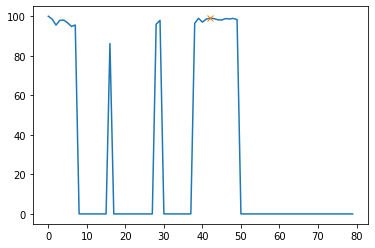

In [163]:
all1 = []
for t in all_scores:
    if len(t) > 0 and t[0] > 0.5:
        #print(t[0])
        all1.append(t[0])
    else:
        all1.append(0)


d_init_x = -1
d_init_y = -1
d_init_z = -1
all1     = []

for i, t in enumerate(all_scores):
    if len(t) > 0 and t[0] > 0.5:
        if d_init_x == -1:
            d_init_x = all_target[i][0][0]
            d_init_y = all_target[i][0][1]
            d_init_z = i
        
        temp_dist = np.min([100, np.linalg.norm([all_target[i][0][0]-d_init_x, all_target[i][0][1]-d_init_y, i-d_init_z])])
        all1.append(temp_dist)
        d_init_x = all_target[i][0][0]
        d_init_y = all_target[i][0][1]
        d_init_z = i
    else:
        all1.append(100)
all1 = 100-np.array(all1)

from scipy.signal import find_peaks

peaks, _ = find_peaks(all1, distance=8, width=4)
#print(a.shape)
plt.plot(all1)
plt.plot(peaks, all1[peaks], 'x')
print(peaks)

slice location  0 49
[[  2.   273.25  44.   388.75]]


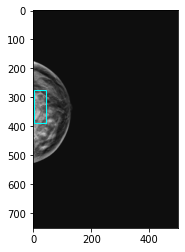

In [32]:
case_index   = 0#random.randint(0, len(valid_dataset))
img, all_target, _    = valid_dataset[case_index]
img          = img.astype('float32')
#img        = a.astype('float32')
#case_index = 0#random.randint(0, img.shape[0]-1)
#case_index = peaks[0]-5
plt.imshow(img[0], cmap='gray')
ax   = plt.gca()
case_index  = 0
print('slice location ', case_index, len(valid_dataset))

if 1:#len(all_target[case_index]) > 0 and all_scores[case_index][0] > 0.2:
    temp  = all_target['boxes'].data.cpu().numpy()#[case_index]
    print(temp)
    #print(case_index, all_scores[case_index])
    index = 0
    #rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='cyan', fill = False)
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

plt.show()
case_index = case_index+1

In [ ]:
# Validation Iteration #10 loss: 0.26083502173423767
# Validation Iteration #20 loss: 0.12475015223026276
# Validation Iteration #30 loss: 0.2311360090970993
# Validation Iteration #40 loss: 0.07870643585920334
# Validation Iteration #50 loss: 0.12904797494411469
# 0.17835015669465065

# Validation Iteration #10 loss: 0.16890683770179749
# Validation Iteration #20 loss: 0.12697485089302063
# Validation Iteration #30 loss: 0.202874094247818
# Validation Iteration #40 loss: 0.1275915801525116
# Validation Iteration #50 loss: 0.16607160866260529
# 0.17254152543842793

# Validation Iteration #10 loss: 0.14864173531532288
# Validation Iteration #20 loss: 0.13806253671646118
# Validation Iteration #30 loss: 0.13079851865768433
# Validation Iteration #40 loss: 0.09259304404258728
# Validation Iteration #50 loss: 0.13366109132766724
# 0.1608045955002308

# Validation Iteration #10 loss: 0.2190426141023636
# Validation Iteration #20 loss: 0.10993507504463196
# Validation Iteration #30 loss: 0.08774184435606003
# Validation Iteration #40 loss: 0.14777813851833344
# Validation Iteration #50 loss: 0.08807449787855148
# 0.1679838129878044

# fasterrcnn_resnet50_dbt22.pth
# Validation Iteration #10 loss: 0.12817245721817017
# Validation Iteration #20 loss: 0.3029731810092926
# Validation Iteration #30 loss: 0.06146375834941864
# Validation Iteration #40 loss: 0.08439958095550537
# Validation Iteration #50 loss: 0.059381939470767975
# 0.10177689090371132

In [ ]:
# [STAR] For doing inference of the model

all_target = []
all_scores = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt22.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    print(loss_dict)
    
    #print(loss_dict[0]['boxes'].data.cpu().numpy())
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

{'boxes': tensor([ 271, 1057,  805, 1490])}
Ground Truth  [ 271 1057  805 1490] 35
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
Scores  [0.97706246 0.4141349  0.13911489 0.10131314]
Prediction  [[ 75.71501  283.47375  163.6579   378.79547 ]
 [  4.241309 263.63602   50.325714 373.7304  ]
 [101.045715 287.99136  151.38869  370.79993 ]
 [ 61.922516 258.55548  184.89377  395.74182 ]]
[ 67 264 201 372]


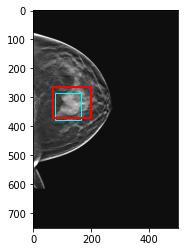

In [257]:
# [STAR] Code to compare the ground truth and predicted mask


case_index   = 35#random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[case_index]
print(b)

print('Ground Truth ', b['boxes'].data.cpu().numpy(), case_index)
print('Prediction ', all_target[case_index])
print('Scores ', all_scores[case_index])

plt.imshow(images[0], cmap='gray')
ax   = plt.gca()

# if(len(all_target1[case_index]) > 0):
#     #print(all_target1[index])
#     #print(all_scores1[index])
    
#     temp  = all_target1[case_index]
#     index = 0
#     rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='yellow', fill = False)
#     ax.add_patch(rect)
# else:
#     print('Not found 9')

if(len(all_target[case_index]) > 0):
    #print(all_target[index])
    #print(all_scores[index])
    
    temp  = all_target[case_index]
    print('Prediction ', temp)
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

temp  = b['boxes'].data.cpu().numpy()//4#all_target[index]
index = 0
print(temp)
rect  = patches.Rectangle((temp[0], temp[1]), temp[2]-temp[0], temp[3]-temp[1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)


#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()
case_index = case_index+1

In [ ]:
# Error cases for fasterrcnn_resnet50_dbt15.pth
Ground Truth  [[ 10.75 304.    51.25 333.75]] 5
Ground Truth  [[ 19.   416.25  63.5  447.75]] 6
Ground Truth  [[188.25 309.5  216.5  369.75]] 7
Ground Truth  [[193.25 389.5  228.   453.5 ]] 8
Ground Truth  [[463.75 150.5  498.5  222.75]] 14
Ground Truth  [[170.   335.25 195.5  362.25]] 23
Ground Truth  [[345.25 414.5  472.25 536.5 ]] 30
Ground Truth  [[451.5  333.75 496.   382.  ]] 34
Ground Truth  [[398.   166.75 468.25 222.  ]] 37
Ground Truth  [[317.75 332.75 388.75 394.  ]] 44
Ground Truth  [[  2.   273.25  44.   388.75]] 45
Ground Truth  [[5.0000e-01 3.9825e+02 6.1500e+01 5.1375e+02]] 46

# Error cases for fasterrcnn_resnet50_dbt14.pth
Ground Truth  [[188.25 309.5  216.5  369.75]] 7
Ground Truth  [[193.25 389.5  228.   453.5 ]] 8
Ground Truth  [[317.75 332.75 388.75 394.  ]] 44
Ground Truth  [[299.25 347.75 324.25 387.  ]] 48

In [9]:
dbtvol = np.fromfile('/media/drilnvm/ubuntudata2/TEST-DBT-RECONS/04140608-LE-L-CC_3000x1200x80.4_0.0005_-0.2_1_15.raw', dtype=np.float32)
dbtvol = np.reshape(dbtvol, [80, 1200, 3000])
print(dbtvol.shape)

(80, 1200, 3000)
